Reed Johnson 6/27/25



#QGIS and GDAL Workflow: Completed locally on Mac. Created Geo environment using miniforge.  

Import .sid into QGIS

Export image and mask as geotiffs from QGIS.  Imporant to export imagery first: 

1.) Right click on layer > export > Save As
2.) Choose Raw Data, Choose file name/location
3.) CRS: EPDG: 6543 - NAD83(2011)/North Carolina (ftUS) - native system for the sid files
4.) For imagery extent = CURRENT LAYER EXTENT, For mask extent = Layer > exported imagery layer (in my case Robeson_2ft)
5.) Resolution:  Original layer resolution is 0.5' per pixel > For ths project I reduced the resolution to 2' per pixel.  Do this for imagery and mask. 
6.) Create options COMPRESS = LZW, TILED = YES, BIGTIFF = YES,  Do this for imagery and mask.  
7.) NoData Values = 0.0, Do this for imagery only.  


For imagery only:  
Using GDAL via terminal to Drop bands 4 and 5, and declare 0's as nodata.  To aid performance use LZW compression and tile the image.  BIGTIFF allows the image to exceed 4GB:
GDAL: 
(geo) ReedJ@Mac ~ % gdal_translate \
  -b 1 -b 2 -b 3 \
  -a_nodata 0 \
  -of GTiff \
  -co COMPRESS=LZW \
  -co TILED=YES \
  -co BIGTIFF=YES \
  /Volumes/GISDrive/exports/robeson_2ft.tif \
  /Volumes/GISDrive/exports/robeson_2ft_rgb_clean.tif


In [ ]:
#=============================================================================
# Solar Farm Semantic Segmentation with U-Net - Reed Johnson - Image Processing
# -----------------------------------------------------------------------------

In [1]:
#Confirming geo environment
import sys
print(sys.executable)

/Users/ReedJ/miniforge3/envs/geo/bin/python


In [2]:
#Declare CWD
import os
os.chdir("/Volumes/GISDrive/solar-farm-practicum/code")

In [ ]:
#Imporing libraries
import re
import shutil
import random
import time
import csv
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import rasterio
from rasterio.enums import Resampling
from rasterio.windows import Window

from shapely.geometry import box

Image Tiling Config:

In [ ]:

#Declares directories and index fields.  
input_tif = "/Volumes/GISDrive/exports/robeson_2ft_rgb_clean.tif"
tile_output_dir = Path("/Volumes/GISDrive/solar-farm-practicum/data/tiles_1024ft")
index_csv_path = tile_output_dir / "tile_index.csv"
shapefile_path = tile_output_dir / "tile_index.shp"

index_fields = ["tile_name", "row", "col", "xmin", "ymax", "xmax", "ymin", "width", "height"]

#Declares pixel size/tile size etc.  
pixel_size_feet = 2
tile_size_feet = 1024
tile_pixels = int(tile_size_feet / pixel_size_feet)
save_only_if_data_present = True

#Defines regex tile name pattern
tile_pattern = re.compile(r"tile_row(\d+)_col(\d+)\.png")


In [3]:
#Creates Output Directory at location defined above, OK if already exists. 
Path(tile_output_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
#Checking for valid data masks 
with rasterio.open(input_tif) as src:
    print("Has mask:", src.mask_flag_enums) 
    print("Nodata value:", src.nodata)
    print("Band count:", src.count)

Has mask: ([<MaskFlags.nodata: 8>], [<MaskFlags.nodata: 8>], [<MaskFlags.nodata: 8>])
Nodata value: 0.0
Band count: 3


Tiling Workflow:  

In [ ]:
print("Tiling")

#Opens the input tif into new src variable.  Declares src_width, src_height, src_transform, and src_profile.  Extracts data into those variables.  
#.transform: performs affine transform and ties pixel location to geographic location.
#.profile: extracts metadata.

with rasterio.open(input_tif) as src:
    src_width = src.width
    src_height = src.height
    src_transform = src.transform
    src_profile = src.profile

    #Uses nested for loop to iterate through pixels and to define tile boundaries based on previously entered tile size.  
    #Outer loop moves across from left to right.
    #Inner loop moves vertically down.  
    #Step is previously defined in tile_pixels.  tqdm adds progress bar to visualize progress.  
    #Window_width/height limits operation to image boundaries. This ensures process stops at the edges of the image.  
    for col in tqdm(range(0, src_width, tile_pixels)):
        for row in range(0, src_height, tile_pixels):
            window_width = min(tile_pixels, src_width - col)
            window_height = min(tile_pixels, src_height - row)

            #Defines window using top left pixel and height/width dimensions.  
            #Applies transform on windows so that each pixel can be tied to geographic coordinates.
            window = Window(col, row, window_width, window_height)
            transform = src.window_transform(window)

            #Reads pixels in each window into tile_data
            #Reads valid data mask for band 1  
            tile_data = src.read(window=window)
            tile_mask = src.read_masks(1, window=window)

            #Uses if/and statement to skip tiles with no valid data.  
            #Will skip if save_only_if_data_present = True AND all of the data in the tile are = 0.  
            #When conditions are met will continue and allow saving of the tile below.   
            if save_only_if_data_present and np.all(tile_mask == 0):
                continue

            #Sets the name structure for tiles to be saved, in this case by row and column.  Also sets file path for saving image.  
            tile_name = f"tile_row{row}_col{col}.png"
            tile_path = tile_output_dir / tile_name

            #Selects first three bands (R,G,& B) dropping any others.
            #Axes are rearranged using transpose and converted to an 8 bit integer (if they arent in that format already) 
            tile_rgb = tile_data[:3]
            tile_array = np.transpose(tile_rgb, (1, 2, 0)).astype(np.uint8)

            #Converts array to pillow object and saves it as as a png. 
            Image.fromarray(tile_array).save(tile_path)

print("DONE.")

Tiling


NameError: name 'rasterio' is not defined

Saving Index and Shapefile

Add descrition and goals for saving out an index and shapefile.  

In [ ]:
#Opens original image to read metadata and coordinate info.  Get the transform information for converting pixels to coordinates.  
#Pulls the coordinate system for the original image.     
with rasterio.open(input_tif) as src:
    transform = src.transform
    crs = src.crs

    #Creates empty "tile records" list for storing location info. 
    tile_records = []
    
    #Loop through all of the image tiles in the tiled path directory with the specified naming pattern using glob.  Extract file names. Pull row and column numbers using regex. 
    #Skip files without the specified pattern.  Converts numbers to integers and assigns them to row & col.    
    for tile_path in tile_output_dir.glob("tile_row*_col*.png"):
        match = tile_pattern.search(tile_path.name)
        if not match:
            continue
        row, col = map(int, match.groups())
        

        #Create a window of pixels in the specified location and dimensions.  Convert windows back to real world coordinates using transform.  Gives X min/max and Y min/max.
        window = Window(col, row, tile_pixels, tile_pixels)
        xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
        
        #Add the parameters below to the blank tile records list for each tile.  
        tile_records.append({
            "tile_name": tile_path.name,
            "row": row,
            "col": col,
            "xmin": xmin,
            "ymax": ymax,
            "xmax": xmax,
            "ymin": ymin,
            "width": tile_pixels,
            "height": tile_pixels,
            "geometry": box(xmin, ymin, xmax, ymax)
        })

#Converts tile records to a dataframe and saves as csv.  
df = pd.DataFrame(tile_records)
df.to_csv(index_csv_path, index=False)

#Converts tile records to geodataframe and saved as shapefile.  
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
gdf.to_file(shapefile_path)

Mask Tiling Workflow

In [ ]:
#Mask Tiling Config
#Similar to tiling config above
input_mask_tif = "/Volumes/GISDrive/solar-farm-practicum/data/exports/robeson_2ft_solar_mask.tif"
mask_tile_dir = Path("/Volumes/GISDrive/solar-farm-practicum/data/masks_1024ft")
mask_csv_path = mask_tile_dir / "mask_index.csv"
mask_shapefile_path = mask_tile_dir / "mask_index.shp"

pixel_size_feet = 2
tile_size_feet = 1024
tile_pixels = int(tile_size_feet / pixel_size_feet)
save_only_if_data_present = False

tile_pattern = re.compile(r"mask_row(\d+)_col(\d+)\.png")

In [6]:
#Creates Output Directory at location defined above, OK if already exists.
Path(mask_tile_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
#Mask Tiling
#Similar process to the imagery tiling and saving of index and shapefile above.  Key differences mentioned below:  

tile_records = []

with rasterio.open(input_mask_tif) as src:
    width, height = src.width, src.height
    transform = src.transform
    crs = src.crs

    for col in tqdm(range(0, width, tile_pixels)):
        for row in range(0, height, tile_pixels):
            window_width = min(tile_pixels, width - col)
            window_height = min(tile_pixels, height - row)
            window = Window(col, row, window_width, window_height)

            #Only reads one band (band 1)
            mask_data = src.read(1, window=window)
            #No RGB manipulation.  
            mask_tile = mask_data.astype(np.uint8)

            tile_name = f"mask_row{row}_col{col}.png"
            tile_path = mask_tile_dir / tile_name
            #No valid data mask check.  

            Image.fromarray(mask_tile).save(tile_path)

            #Index and shapefile creation are part of the tiling process instead of an additional step.  
            xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
            tile_records.append({
                "tile_name": tile_name,
                "row": row,
                "col": col,
                "xmin": xmin,
                "ymax": ymax,
                "xmax": xmax,
                "ymin": ymin,
                "width": window_width,
                "height": window_height,
                "geometry": box(xmin, ymin, xmax, ymax)
            })

#save dataframe and geodataframe to csvs
df = pd.DataFrame(tile_records)
df.to_csv(mask_csv_path, index=False)

gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
gdf.to_file(mask_shapefile_path)


100%|██████████| 196/196 [01:06<00:00,  2.97it/s]


At this point I brought both shapefiles (tiles and mask tiles) into QGIS and checked their alignment.

Double Check of Image Tile/Mask Tile Pair

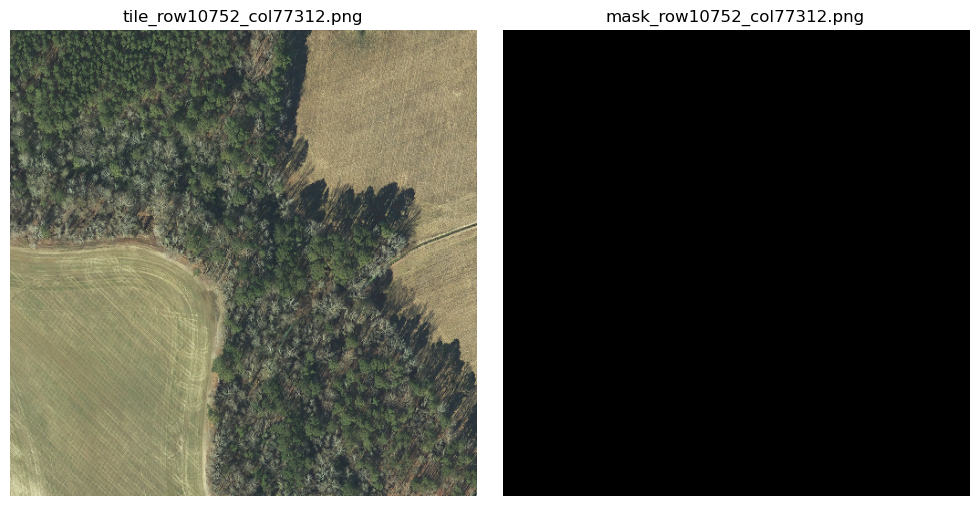

In [ ]:
#Displays random image/tile pair
tile_output_dir = Path("/Volumes/GISDrive/solar-farm-practicum/data/tiles_1024ft")
mask_tile_dir = Path("/Volumes/GISDrive/solar-farm-practicum/data/masks_1024ft")


#open tile index csv and convert to df.  
df = pd.read_csv("/Volumes/GISDrive/solar-farm-practicum/data/tiles_1024ft/tile_index.csv")
#select random row (equivalent to one tile) of data
random_row = df.sample(n=1).iloc[0]

tile_filename = random_row["tile_name"]

#extract row and column from random tile data and place them into standard naming structure. 
row, col = random_row["row"], random_row["col"]
mask_filename = f"mask_row{row}_col{col}.png"

tile_path = tile_output_dir / tile_filename
mask_path = mask_tile_dir / mask_filename

#open the randomply selected tile and mask
tile_img = Image.open(tile_path)
mask_img = Image.open(mask_path)

#create two paned plot with random tile and mask selected above.  
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(tile_img)
axs[0].set_title(tile_filename)
axs[0].axis("off")

axs[1].imshow(mask_img, cmap="gray")
axs[1].set_title(mask_filename)
axs[1].axis("off")

plt.tight_layout()
plt.show()

Removing Extra Mask Tiles
At this point there are a lot of extra mask tiles that correspoded to the blank padding files which were removed above.  Below they are removed.  

In [ ]:
# Paths
image_dir = "/Volumes/GISDrive/solar-farm-practicum/data/tiles_1024ft"
mask_dir = "/Volumes/GISDrive/solar-farm-practicum/data/masks_1024ft"
unused_mask_dir = "/Volumes/GISDrive/solar-farm-practicum/data/masks_unused"

# Create backup folder if needed
os.makedirs(unused_mask_dir, exist_ok=True)

# Get image tile IDs by stripping 'tile_' prefix
image_ids = {
    f.replace("tile_", "").replace(".png", "") 
    for f in os.listdir(image_dir) 
    if f.startswith("tile_") and f.endswith(".png")
}

# Get mask tile IDs by stripping 'mask_' prefix
mask_ids = {
    f.replace("mask_", "").replace(".png", "") 
    for f in os.listdir(mask_dir) 
    if f.startswith("mask_") and f.endswith(".png")
}

# Find unmatched mask IDs
unmatched_ids = mask_ids - image_ids
print(f"Found {len(unmatched_ids)} unmatched mask tiles.")

# Move unmatched masks
for tile_id in unmatched_ids:
    src = os.path.join(mask_dir, f"mask_{tile_id}.png")
    dst = os.path.join(unused_mask_dir, f"mask_{tile_id}.png")
    if os.path.exists(src):
        shutil.move(src, dst)

print("Done. Unmatched masks moved safely.")

Found 18499 unmatched mask tiles.
Done. Unmatched masks moved safely.


Remove Partial Edge Tiles
There were still a number of partial edge tiles in the data.  I remove them below. 

In [ ]:
# Set file paths for original image and mask directories
image_dir = "/Volumes/GISDrive/solar-farm-practicum/data/tiles_1024ft"
mask_dir = "/Volumes/GISDrive/solar-farm-practicum/data/masks_1024ft"

# Set paths for backup folders where non-512x512 tiles will be moved
backup_image_dir = image_dir + "_edge_trimmed"
backup_mask_dir = mask_dir + "_edge_trimmed"

# Create backup directories if they don't already exist
os.makedirs(backup_image_dir, exist_ok=True)
os.makedirs(backup_mask_dir, exist_ok=True)

# Loop through every file in the image directory
for file in os.listdir(image_dir):
    if not file.endswith(".png"):
        continue

    # Construct full paths to the image and related mask
    image_path = os.path.join(image_dir, file)
    mask_path = os.path.join(mask_dir, file.replace("tile_", "mask_"))

    #Open image and mask and check size, move if does not equal standard dimension of 512x512.   
    try:
        img = Image.open(image_path)
        mask = Image.open(mask_path)

        if img.size != (512, 512) or mask.size != (512, 512):
            print(f"Moving: {file} — Image: {img.size}, Mask: {mask.size}")
            shutil.move(image_path, os.path.join(backup_image_dir, file))
            shutil.move(mask_path, os.path.join(backup_mask_dir, file.replace("tile_", "mask_")))
    
    #Print error message if process fails
    except Exception as e:
        print(f"Error on {file}: {e}")

Remove Mostly Black Image Tiles
There were still a number of tiles in the image data that were predominantly black "no data."  Below I remove those and their corresponding masks.  

In [ ]:
# Set file paths for original image and mask directories
image_dir = "/Volumes/GISDrive/solar-farm-practicum/data/tiles_1024ft"
mask_dir = "/Volumes/GISDrive/solar-farm-practicum/data/masks_1024ft"

# Define backup directories where edge tiles will be moved.  
backup_image_dir = image_dir + "_edge_trimmed_v2"
backup_mask_dir = mask_dir + "_edge_trimmed_v2"

# Create backup directories
os.makedirs(backup_image_dir, exist_ok=True)
os.makedirs(backup_mask_dir, exist_ok=True)

#Define function to determine if tile is greater than 90% black. 
def is_mostly_black(image, threshold=0.90):
    #Convert image to numpy array
    arr = np.array(image).astype(np.float32) / 255.0  # Normalize to 0–1
    grayscale = arr.mean(axis=2) if arr.ndim == 3 else arr  # Convert to grayscale if RGB
    black_ratio = np.sum(grayscale < 0.05) / grayscale.size  # Calc percent of pixels that are close to black
    return black_ratio > threshold # Return True if more than `threshold` percent of pixels are black

# Loop through the pngs
for file in os.listdir(image_dir):
    if not file.endswith(".png"):
        continue

    #Paths to join images and masks
    image_path = os.path.join(image_dir, file)
    mask_path = os.path.join(mask_dir, file.replace("tile_", "mask_"))

    # Open image and mask.  Perform size checks, mostly black check, move to backup if conditions are met.  
    try:
        img = Image.open(image_path)
        mask = Image.open(mask_path)

        img_valid_size = img.size == (512, 512)
        mask_valid_size = mask.size == (512, 512)
        img_mostly_black = is_mostly_black(img)

        if (not img_valid_size or not mask_valid_size) or img_mostly_black:
            print(f"Removing edge tile: {file} — Black Ratio Too High")
            shutil.move(image_path, os.path.join(backup_image_dir, file))
            shutil.move(mask_path, os.path.join(backup_mask_dir, file.replace("tile_", "mask_")))
    
    #Print error if process fails.  
    except Exception as e:
        print(f"Error on {file}: {e}")

Removing edge tile: tile_row105472_col41984.png — Black Ratio Too High
Removing edge tile: tile_row109568_col44544.png — Black Ratio Too High
Removing edge tile: tile_row104960_col74240.png — Black Ratio Too High
Removing edge tile: tile_row20992_col84992.png — Black Ratio Too High
Removing edge tile: tile_row104960_col41984.png — Black Ratio Too High
Removing edge tile: tile_row22016_col35328.png — Black Ratio Too High
Removing edge tile: tile_row106496_col41984.png — Black Ratio Too High
Removing edge tile: tile_row9728_col82432.png — Black Ratio Too High
Removing edge tile: tile_row84992_col94208.png — Black Ratio Too High
Removing edge tile: tile_row84992_col21504.png — Black Ratio Too High
Removing edge tile: tile_row22016_col35840.png — Black Ratio Too High
Removing edge tile: tile_row22016_col36352.png — Black Ratio Too High
Removing edge tile: tile_row104960_col75776.png — Black Ratio Too High
Removing edge tile: tile_row41984_col97280.png — Black Ratio Too High
Removing edge t

Calculate Number of Positive Mask Tiles and Total Number of Mask Tiles
Also at this point I manually checked the number of image tiles nad mask tiles in the data.  They matched.  

In [ ]:
#Mask directory. 
mask_dir = "/Volumes/GISDrive/solar-farm-practicum/data/masks_1024ft"

#Counter for non empty masks
non_empty = 0

#List of all png filenames.  
all_masks = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

#Loop over masks. 
for fname in all_masks:
    mask_path = os.path.join(mask_dir, fname)
    mask = Image.open(mask_path).convert("L") #Convert mask to grayscale
    mask_array = np.array(mask) #Convert to numpy array

    #If any pixel is valued at 255 (Solar farm = yes) count as non-empty. 
    if np.any(mask_array == 255):
        non_empty += 1

#Print non empty and total number of masks.  
print(f"🧹 Non-empty masks: {non_empty} / {len(all_masks)}")

🧹 Non-empty masks: 235 / 28418


At this point all tiles and csvs were moved to runpod.io.  Please see 02_main_unet_pipeline for next steps.  



TENSORFLOW NOTES 

Install

```
conda create -n tfgpu python=3.10 -y && conda activate tfgpu
conda install -c apple tensorflow-deps -y     # Install Apple dependencies
pip install tensorflow-macos  # Install TensorFlow optimized for Apple Silicon
pip install tensorflow-metal  # GPU acceleration via Metal
conda install -c conda-forge unrar ffmpeg -y
```


OR 

conda create -n tfgpu python=3.10 -y && conda activate tfgpu
conda install -c apple tensorflow-deps -y # Install Apple dependencies pip install tensorflow-macos # Install TensorFlow optimized for Apple Silicon pip install tensorflow-metal # GPU acceleration via Metal
conda install -c conda-forge unrar ffmpeg -y

In [ ]:
# mac_tf.txt from Mujtaba

# import os
# import numpy as np
# import tensorflow as tf
# import tf2onnx
# import onnx
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau, LearningRateScheduler
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from config import parse_opts
# from utils.lib_ucf import UCFDataSet
# from utils.lib_createDir import prepare_output_dirs, print_config, write_config
# from utils.lib_visdata import save_history
# from models.convNeXt import create_model

# # Apple Silicon M3 Pro GPU optimization settings
# os.environ['TF_METAL_DEVICE_FORCE_MEMORY_GROWTH'] = 'true'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce logging verbosity
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable certain optimizations

# # Parse configurations
# config = parse_opts()
# config.batch_size = max(2, config.batch_size // 2)  # Halve the batch size, minimum 2
# print(f"Using batch size: {config.batch_size}")

# config = prepare_output_dirs(config)
# print_config(config)
# write_config(config, os.path.join(config.save_dir, 'config.json'))

# print("TensorFlow version:", tf.__version__)
# physical_devices = tf.config.list_physical_devices()
# print("All devices:", physical_devices)

# # Check available GPUs
# physical_devices = tf.config.list_physical_devices('GPU')
# print(f"Available GPUs: {physical_devices}")

# # Enable mixed precision for better performance on Apple Silicon
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
# print("Mixed precision enabled (float16)")
# policy = tf.keras.mixed_precision.global_policy()
# print(f"\nMixed precision policy: {policy}")
# print(f"Compute dtype: {policy.compute_dtype}")
# print(f"Variable dtype: {policy.variable_dtype}")

# # Configure GPU memory allocation
# if physical_devices:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             physical_devices[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]  # 8GB limit
#         )
#         print("Metal GPU memory limit configured")
#     except Exception as e:
#         print(f"Error configuring GPU: {e}")
#         print("Falling back to CPU training")
#         os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
